<img src = '../../sb_tight.png'>
<h1 align = 'center'> Capstone Project 2: Pump It Up </h1>

---

### Notebook 3: Pre-processing
**Author:<br>
Tashi T. Gurung**<br>
**hseb.tashi@gmail.com**

### About the project:
The **objective** of this project is to **predict the failure of water points** spread accross Tanzania before they occur.

50% of Tanzania's population do not have access to safe water. Among other sources, Tanzanians depend on water points mostly pumps (~60K) spread across Tanzania. Compared to other infrastructure projects, water point projects consist of a huge number of inspection points that are geographically spread out. Gathering data on the condition of these pumps has been a challenge. From working with local agencies, to implementing mobile based crowd sourcing projects, none have produced satisfactory results.

The lack of quality data creates a number of problem for a stakeholder like the Tanzanian Government, specifically the Ministry of Water. Consequences include not only higher maintainence costs, but also all the problems and nuanced issues faced by communities when their access to water is compromised or threatened.

While better data collection infrastructure should be built overtime, this project (with its model(s), various analysis, and insights) will be key for efficient resource allocation to maximize the number of people and communities with access to water.
In the long run, it will assist stake holders in and project planning, and even local, regional and national level policy formation. 

### About the notebook:


What we do here..

<h1> Import libraries and datasets </h1>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv('../data/interim/df.csv')

To-Do:
1. Shortlist variables
2. Figure out how to encode categorical variables

In [3]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage',
       'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'target_var'],
      dtype='object')

<h2> Features </h2>

<ol>
    <li> <a href = '#FE_age'> Feature: age </a> </li>
</ol>

<a id = 'FE_age'><h3> Feature Engineering: age </h3> </a>

In [4]:
df[['construction_year', 'date_recorded']].dtypes

construction_year     int64
date_recorded        object
dtype: object

In [5]:
df[['construction_year', 'date_recorded']].head()

,construction_year,date_recorded
0,1999,2011-03-14
1,2010,2013-03-06
2,2009,2013-02-25
3,1986,2013-01-28
4,0,2011-07-13


**Construction Year**

~35% of the data is missing i.e. 0

In [6]:
(df['construction_year']==0).sum()/len(df)

0.34863636363636363

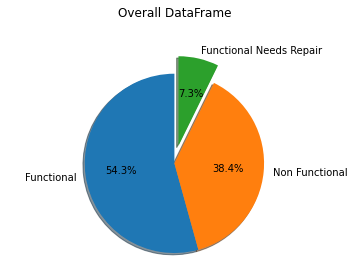

In [7]:
s = df['target_var'].value_counts()/len(df)

fig, ax = plt.subplots()

ax.pie(s.values, labels=s.index.str.title(), 
       autopct='%1.1f%%',
       explode = (0,0,0.2),
       shadow=True, startangle=90)

ax.set_title('Overall DataFrame',
             pad = 30)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal');

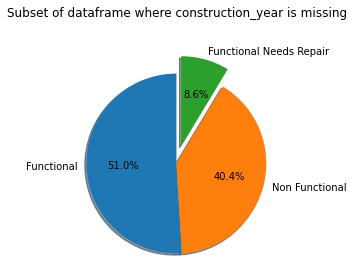

In [8]:
s = df[df['construction_year']==0]['target_var'].value_counts(normalize = True)
fig, ax = plt.subplots()

ax.pie(s.values, labels=s.index.str.title(), 
       autopct='%1.1f%%',
       explode = (0,0,0.2),
       shadow=True, startangle=90)

ax.set_title('Subset of dataframe where construction_year is missing',
             pad = 30)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  ;

Impute **mean** of each subclass

In [9]:
s =df[df['construction_year']!= 0].groupby('target_var')['construction_year'].mean()
s = round(s,2)
s

target_var
functional                 1999.94
functional needs repair    1995.26
non functional             1992.40
Name: construction_year, dtype: float64

Imputing

In [10]:
df['imputed_construction_year'] = np.where((df['construction_year'] == 0) & (df['target_var'] == 'functional'),\
                              s['functional'], df['construction_year'])
df['imputed_construction_year'] = np.where((df['imputed_construction_year'] == 0) & (df['target_var'] == 'functional needs repair'),\
                              s['functional needs repair'], df['imputed_construction_year'])
df['imputed_construction_year'] = np.where((df['imputed_construction_year'] == 0) & (df['target_var'] == 'non functional'),\
                              s['non functional'], df['imputed_construction_year'])

mean of original column

In [11]:
round(df[df['construction_year'] != 0]['construction_year'].mean(),2)

1996.81

mean of imputed column

In [12]:
round(df['imputed_construction_year'].mean(),2)

1996.7

**date_recorded**

In [13]:
df['date_recorded'].isna().sum()

0

In [14]:
df['date_recorded'].min()

'2002-10-14'

In [15]:
df['date_recorded'].max()

'2013-12-03'

Create a new variable: **date_recorded_year** <br>
by extracting it from variable 'date_recorded'

In [16]:
df['date_recorded_year'] = pd.DatetimeIndex(df['date_recorded']).year
df['date_recorded_month'] = pd.DatetimeIndex(df['date_recorded']).month/12

df['eng_date_recorded'] = round(df['date_recorded_year'] + df['date_recorded_month'],2)
df['eng_date_recorded']

0        2011.25
1        2013.25
2        2013.17
3        2013.08
4        2011.58
          ...   
59395    2013.42
59396    2011.42
59397    2011.33
59398    2011.25
59399    2011.25
Name: eng_date_recorded, Length: 59400, dtype: float64

<h3> Calcuate AGE </h3>

In [17]:
df['eng_age'] = df['eng_date_recorded'] - df['imputed_construction_year']

In [21]:
df['target_var'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

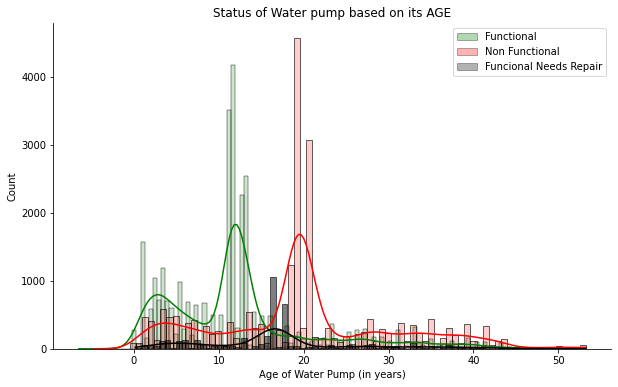

In [22]:
fig, ax = plt.subplots(figsize = (10,6))

bool_mask_functional = df['target_var'] == 'functional'
sns.histplot(df[bool_mask_functional]['eng_age'], 
             color = 'g',
             kde = True,
             ax = ax,
             alpha = 0.2)

bool_mask_repairs = df['target_var'] == 'non functional'
sns.histplot(df[bool_mask_repairs]['eng_age'], 
             color = 'r',
             kde = True,
             ax = ax,
             alpha = 0.2)

bool_mask_repairs = df['target_var'] == 'functional needs repair'
sns.histplot(df[bool_mask_repairs]['eng_age'], 
             color = 'black',
             kde = True,
             ax = ax)

# Custom Legend
legend_elements = [Patch(facecolor='g',
                         edgecolor='black',
                         alpha = 0.3,
                         label='Functional'),
                   
                   Patch(facecolor='r',
                         edgecolor='black',
                         alpha = 0.3,
                         label='Non Functional'),
                  
                  Patch(facecolor='black',
                         edgecolor='black',
                         alpha = 0.3,
                         label='Funcional Needs Repair')]

ax.legend(handles=legend_elements, loc='best')

plt.title('Status of Water pump based on its AGE')
plt.xlabel('Age of Water Pump (in years)')

sns.despine();

**Comments:**<br>
The older the pump, the more likely it is not functional

<a id = 'installer_bool'><h3> Feature Engineering: installer_bool </h3> </a>

In [23]:
df['installer_bool'] = np.where(df['installer'] == 'DWE', 1, 0)

<h2> Add features </h2>

gps_height

34% of data missing

In [24]:
(df['gps_height'] == 0).sum()/len(df)

0.3440740740740741

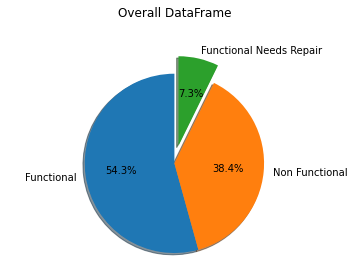

In [25]:
s = df['target_var'].value_counts()/len(df)

fig, ax = plt.subplots()

ax.pie(s.values, labels=s.index.str.title(), 
       autopct='%1.1f%%',
       explode = (0,0,0.2),
       shadow=True, startangle=90)

ax.set_title('Overall DataFrame',
             pad = 30)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal');

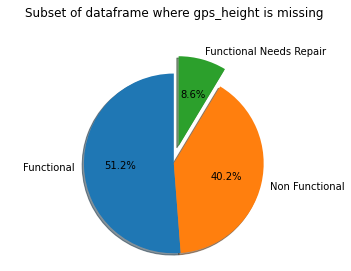

In [26]:
s = df[df['gps_height']==0]['target_var'].value_counts(normalize = True)
fig, ax = plt.subplots()

ax.pie(s.values, labels=s.index.str.title(), 
       autopct='%1.1f%%',
       explode = (0,0,0.2),
       shadow=True, startangle=90)

ax.set_title('Subset of dataframe where gps_height is missing',
             pad = 30)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  ;

SIMILAR APPROACH to Constrution_year

Impute **mean** of each subclass

In [27]:
s =df[df['gps_height']!= 0].groupby('target_var')['gps_height'].mean()
s = round(s,2)
s

target_var
functional                 1095.73
functional needs repair    1060.84
non functional              896.95
Name: gps_height, dtype: float64

Imputing

In [28]:
df['imputed_gps_height'] = np.where((df['gps_height'] == 0) & (df['target_var'] == 'functional'),\
                              s['functional'], df['gps_height'])
df['imputed_gps_height'] = np.where((df['imputed_gps_height'] == 0) & (df['target_var'] == 'functional needs repair'),\
                              s['functional needs repair'], df['imputed_gps_height'])
df['imputed_gps_height'] = np.where((df['imputed_construction_year'] == 0) & (df['target_var'] == 'non functional'),\
                              s['non functional'], df['imputed_gps_height'])

quantity

In [29]:
df['quantity'].isna().sum()

0

In [30]:
df['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

<h2> Model Building </h2>

**Logistic Regression**

In [44]:
feature_cols = ['eng_age','installer_bool', 'imputed_gps_height']
dummy_cols = ['quantity', 'extraction_type', 'payment_type',
              'water_quality', 'source', 'waterpoint_type']

feature_cols.extend(dummy_cols)

In [45]:
data = df[feature_cols].copy()

For dummy columns

In [46]:
data = pd.get_dummies(data, columns = dummy_cols, drop_first = True)

In [47]:
data.head()

,eng_age,installer_bool,imputed_gps_height,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,...,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,12.25,0,1390.00,1,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
1,3.25,0,1399.00,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,4.17,0,686.00,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,27.08,0,263.00,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,11.64,0,1095.73,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [48]:
X = data.values # predictor
X.shape

(59400, 52)

In [57]:
replace_dict = {'functional':0,'non functional':1, 'functional needs repair':1}
y= np.array([replace_dict[i] for i in df['target_var'].values]) # target

In [58]:
y.shape

(59400,)

In [59]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, random_state=25)

Logistic Regression

In [60]:
clf = LogisticRegression(max_iter = 2500)

# Fit the model on the training data.
clf.fit(Xlr, ylr) 

LogisticRegression(max_iter=2500)

In [61]:
y_predict_test = clf.predict(Xtestlr)

print("[Test] Accuracy score (y_predict_test, ytestlr):",accuracy_score(y_predict_test, ytestlr))

print("\n")
print("[Test] Accuracy score: (ytestlr, y_predict_test)",accuracy_score(ytestlr, y_predict_test))

# AJS: also printout the training score
y_predict_training = clf.predict(Xlr)
print("\n")
print("[Training] Accuracy score: (ylr, y_predict_training)",accuracy_score(ylr, y_predict_training))

[Test] Accuracy score (y_predict_test, ytestlr): 0.7977777777777778


[Test] Accuracy score: (ytestlr, y_predict_test) 0.7977777777777778


[Training] Accuracy score: (ylr, y_predict_training) 0.7887317620650954


In [62]:
from sklearn.metrics import classification_report, confusion_matrix

print("[Training Classification Report]")
print(classification_report(ylr, y_predict_training))

print("[Test Classification Report]")
print(classification_report(ytestlr, y_predict_test))

[Training Classification Report]
              precision    recall  f1-score   support

           0       0.77      0.87      0.82     24162
           1       0.82      0.69      0.75     20388

    accuracy                           0.79     44550
   macro avg       0.79      0.78      0.78     44550
weighted avg       0.79      0.79      0.79     44550

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      8097
           1       0.83      0.70      0.76      6753

    accuracy                           0.80     14850
   macro avg       0.80      0.79      0.79     14850
weighted avg       0.80      0.80      0.80     14850



In [66]:
tn, fp, fn, tp = confusion_matrix(ytestlr, y_predict_test).ravel()

In [63]:
confusion_matrix(ytestlr, y_predict_test)

array([[7116,  981],
       [2022, 4731]], dtype=int64)

''

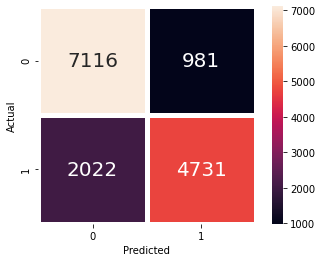

In [64]:
sns.heatmap(confusion_matrix(ytestlr, y_predict_test), 
            annot = True, 
            square = True,
            linewidths = 5,
            annot_kws = {'size' : 20},
            fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
;

In [68]:
fp

981

In [69]:
fn

2022

The **precision** is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

What's more important? What is the goal? <br>
Goal1: <br>
Make sure most water points are repaired, while minimizing costs. You'd want a higher **recall**. You would not want to miss out on positives. It's okay to deploy inspectors to projects, that might not need them<br>

Goal2: <br>
Budget is extremely limited, only go to those water points where inspection, and repair is absolutely needed